# Vector Auto Regression

in SARIMAX , the forecast variable y_t was influenced by the exogeneous predictor variable,but 
not vice versa.

That is, the occurance of holiday affected restarant patronage but the other way around

there are some cases where variables affect each other.
So in this situation VAR models are used.

<img 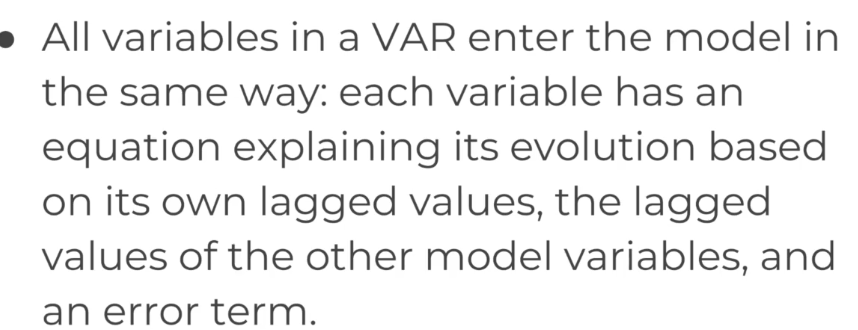

VAR modeling does not require as much knowledge about the forces influencing
a variable.

the only prior knowledge required is a list of variables which can be hypothesized 
to affect each other intertemporally.

 <img 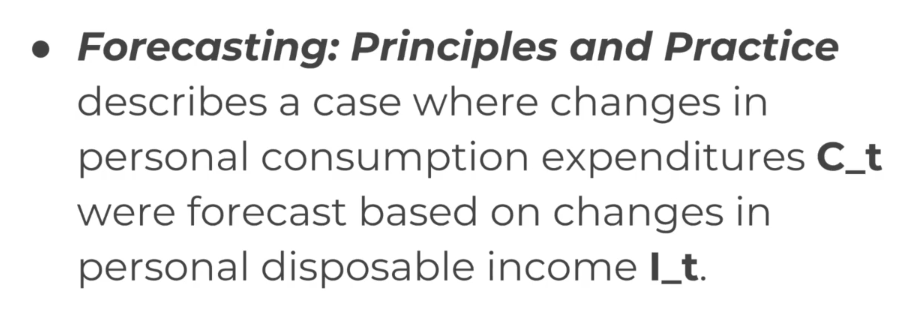

  We would forecast into the future using VAR for two time series that we believe
have effects on eachother.
We will use M2 money stock and personal consumption from FRED

In [1]:
import pandas as pd
import numpy as np

In [6]:
#Loading specific forecasting tools
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('../Data/M2SLMoneyStock.csv',index_col=0,parse_dates=True)
df.index.freq  = 'MS'

In [5]:
sp = pd.read_csv('../Data/PCEPersonalSpending.csv',index_col=0,parse_dates=True)
sp.index.freq = 'MS'

In [7]:
df.head()

,Money
Date,
1995-01-01,3492.4
1995-02-01,3489.9
1995-03-01,3491.1
1995-04-01,3499.2
1995-05-01,3524.2


In [8]:
sp.head()

,Spending
Date,
1995-01-01,4851.2
1995-02-01,4850.8
1995-03-01,4885.4
1995-04-01,4890.2
1995-05-01,4933.1


In [9]:
df = df.join(sp)

In [10]:
df.head()

,Money,Spending
Date,,
1995-01-01,3492.4,4851.2
1995-02-01,3489.9,4850.8
1995-03-01,3491.1,4885.4
1995-04-01,3499.2,4890.2
1995-05-01,3524.2,4933.1


In [11]:
df.shape

(252, 2)

In [13]:
df = df.dropna()

In [14]:
df.shape

(252, 2)

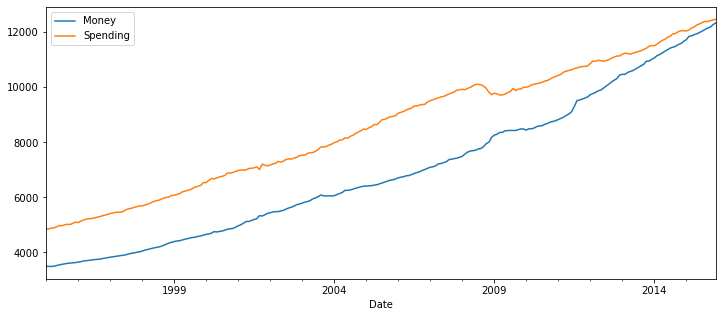

In [15]:
df.plot(figsize=(12,5))

Checking for stationarity and will look if any differencing is required or not

In [16]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [17]:
adf_test(df['Money'])

Augmented Dickey-Fuller Test: 
ADF test statistic        4.239022
p-value                   1.000000
# lags used               4.000000
# observations          247.000000
critical value (1%)      -3.457105
critical value (5%)      -2.873314
critical value (10%)     -2.573044
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [18]:
adf_test(df['Spending'])

Augmented Dickey-Fuller Test: 
ADF test statistic        0.149796
p-value                   0.969301
# lags used               3.000000
# observations          248.000000
critical value (1%)      -3.456996
critical value (5%)      -2.873266
critical value (10%)     -2.573019
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


We need to apply differencing on both the columns

In [21]:
df_transformed = df.diff()

In [23]:
df.head()

,Money,Spending
Date,,
1995-01-01,3492.4,4851.2
1995-02-01,3489.9,4850.8
1995-03-01,3491.1,4885.4
1995-04-01,3499.2,4890.2
1995-05-01,3524.2,4933.1


In [24]:
df_transformed

,Money,Spending
Date,,
1995-01-01,NaN,NaN
1995-02-01,-2.5,-0.4
1995-03-01,1.2,34.6
1995-04-01,8.1,4.8
1995-05-01,25.0,42.9
...,...,...
2015-08-01,51.5,38.6
2015-09-01,57.0,-1.2
2015-10-01,33.9,23.3


In [25]:
adf_test(df_transformed['Money'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -2.057404
p-value                   0.261984
# lags used              15.000000
# observations          235.000000
critical value (1%)      -3.458487
critical value (5%)      -2.873919
critical value (10%)     -2.573367
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [26]:
adf_test(df_transformed['Spending'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -7.226974e+00
p-value                 2.041027e-10
# lags used             2.000000e+00
# observations          2.480000e+02
critical value (1%)    -3.456996e+00
critical value (5%)    -2.873266e+00
critical value (10%)   -2.573019e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


The Money columns is still not stationary so we will need to apply another differencing on it

applying 2nd degree differncing to both the columns to get aligned data

In [27]:
df_transformed = df_transformed.diff().dropna()

In [28]:
df_transformed

,Money,Spending
Date,,
1995-03-01,3.7,35.0
1995-04-01,6.9,-29.8
1995-05-01,16.9,38.1
1995-06-01,-0.3,1.5
1995-07-01,-6.2,-51.7
...,...,...
2015-08-01,-0.7,-8.5
2015-09-01,5.5,-39.8
2015-10-01,-23.1,24.5


In [29]:
adf_test(df_transformed['Money'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -7.077471e+00
p-value                 4.760675e-10
# lags used             1.400000e+01
# observations          2.350000e+02
critical value (1%)    -3.458487e+00
critical value (5%)    -2.873919e+00
critical value (10%)   -2.573367e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [30]:
adf_test(df_transformed['Spending'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -8.760145e+00
p-value                 2.687900e-14
# lags used             8.000000e+00
# observations          2.410000e+02
critical value (1%)    -3.457779e+00
critical value (5%)    -2.873609e+00
critical value (10%)   -2.573202e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


Now both the columns are stationary

In [31]:
df_transformed.shape

(250, 2)

#### training test split

In [32]:
#Number of observations
nobs = 12


In [35]:
train = df_transformed[:-nobs] # start -- begenning of df --> go to -12 from end

In [36]:
test = df_transformed[-nobs:] # start at -12 from end of DF--> go to end of df

In [37]:
test

,Money,Spending
Date,,
2015-01-01,-15.5,-26.6
2015-02-01,56.1,52.4
2015-03-01,-102.8,39.5
2015-04-01,30.9,-40.4
2015-05-01,-15.8,38.8
2015-06-01,14.0,-34.1
2015-07-01,6.7,6.9
2015-08-01,-0.7,-8.5
2015-09-01,5.5,-39.8


Choosing order of VAR

## Gridsearch for order p AR of VAR Model

In [38]:
model = VAR(train)

In [39]:
for p in [1,2,3,4,5,6,7]:#range 8
    
    results = model.fit(p)
    print(f'ORDER {p}')
    print(f'AIC:{results.aic}')
    print('\n')

ORDER 1
AIC:14.178610495220896


ORDER 2
AIC:13.955189367163703


ORDER 3
AIC:13.849518291541038


ORDER 4
AIC:13.827950574458281


ORDER 5
AIC:13.78730034460964


ORDER 6
AIC:13.799076756885809


ORDER 7
AIC:13.797638727913972




we will choose the model from above whose AIC is low.. so selecting order5

In [40]:
results = model.fit(5)

In [41]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 10, Jan, 2022
Time:                     11:06:12
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    14.1131
Nobs:                     233.000    HQIC:                   13.9187
Log likelihood:          -2245.45    FPE:                    972321.
AIC:                      13.7873    Det(Omega_mle):         886628.
--------------------------------------------------------------------
Results for equation Money
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.516683         1.782238            0.290           0.772
L1.Money           -0.646232         0.068177           -9.479           0.000
L1.Spending        -0.107411         0.051388           -2.090      

### Forecasting the future

In [42]:
# Grab 5 lagged values, right before the test starts!
#numpy array we have to pass

In [46]:
train.values

array([[ 3.700e+00,  3.500e+01],
       [ 6.900e+00, -2.980e+01],
       [ 1.690e+01,  3.810e+01],
       [-3.000e-01,  1.500e+00],
       [-6.200e+00, -5.170e+01],
       [ 3.100e+00,  4.240e+01],
       [-8.500e+00, -1.990e+01],
       [-1.800e+00, -2.180e+01],
       [-4.800e+00,  4.830e+01],
       [ 3.100e+00,  2.000e-01],
       [ 8.800e+00, -5.370e+01],
       [-4.400e+00,  5.890e+01],
       [ 1.110e+01, -6.600e+00],
       [-1.430e+01, -5.800e+00],
       [ 1.100e+00, -1.890e+01],
       [ 1.100e+00, -9.800e+00],
       [ 1.600e+00,  1.610e+01],
       [-7.600e+00,  1.000e+00],
       [ 2.400e+00, -1.500e+00],
       [ 7.900e+00,  1.030e+01],
       [ 1.900e+00, -9.200e+00],
       [ 1.100e+00,  4.700e+00],
       [-6.000e+00,  5.100e+00],
       [-2.700e+00, -9.600e+00],
       [ 3.300e+00, -2.700e+00],
       [ 1.200e+00, -1.510e+01],
       [-4.300e+00, -4.200e+00],
       [ 5.000e+00,  3.310e+01],
       [ 1.100e+00,  2.060e+01],
       [ 1.570e+01, -1.640e+01],
       [-1

In [47]:
train.shape

(238, 2)

In [48]:
# we just need last 5 lagged values of train set.. as these values are just before test set starts

In [49]:
lagged_values = train.values[-5:]

In [51]:
lagged_values ## here we have lag of 5 and 2 time series so we are passing  last 

array([[-31.9,  40.3],
       [  5.6, -70.7],
       [ 25.5,  52.5],
       [-21.3, -37.2],
       [ 39.5, -17.8]])

In [52]:
train.values[-5:].shape

(5, 2)

In [54]:
# parameters in VAR to pass
# p -> no. of lag order here it is 5, K is no. of time series terms. here we are compairing 2 TS
# y --> no.of steps of future we wanna predict.. here to compare against test so it will be 12
# we cant pass df directly to y as it asks for ndarray.. so we will call df.values

z= results.forecast(y=lagged_values,steps=12)


In [55]:
z

array([[-16.99527634,  36.14982003],
       [ -3.17403756, -11.45029844],
       [ -0.377725  ,  -6.68496939],
       [ -2.60223305,   5.47945777],
       [  4.228557  ,  -2.44336505],
       [  1.55939341,   0.38763902],
       [ -0.99841027,   3.88368011],
       [  0.36451042,  -2.3561014 ],
       [ -1.21062726,  -1.22414652],
       [  0.22587712,   0.786927  ],
       [  1.33893884,   0.18097449],
       [ -0.21858453,   0.21275046]])

In [56]:
#Transforming this result again into dataframe

In [57]:
idx = pd.date_range('2015-01-01',periods=12,freq='MS')

In [58]:
idx

DatetimeIndex(['2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
               '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01'],
              dtype='datetime64[ns]', freq='MS')

In [61]:
df_forecast =pd.DataFrame(data=z,index=idx,columns=['Money_2d','Spending_2d'])

In [62]:
df_forecast

,Money_2d,Spending_2d
2015-01-01,-16.995276,36.149820
2015-02-01,-3.174038,-11.450298
2015-03-01,-0.377725,-6.684969
2015-04-01,-2.602233,5.479458
2015-05-01,4.228557,-2.443365
2015-06-01,1.559393,0.387639
2015-07-01,-0.998410,3.883680
2015-08-01,0.364510,-2.356101
2015-09-01,-1.210627,-1.224147
2015-10-01,0.225877,0.786927


#Invert The transfromation

In [64]:
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['Money1d'] = (df['Money'].iloc[-nobs-1]-df['Money'].iloc[-nobs-2]) + df_forecast['Money_2d'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['MoneyForecast'] = df['Money'].iloc[-nobs-1] + df_forecast['Money1d'].cumsum()

In [65]:
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['Spending1d'] = (df['Spending'].iloc[-nobs-1]-df['Spending'].iloc[-nobs-2]) + df_forecast['Spending_2d'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['SpendingForecast'] = df['Spending'].iloc[-nobs-1] + df_forecast['Spending1d'].cumsum()

In [66]:
df_forecast.head()

,Money_2d,Spending_2d,Money1d,MoneyForecast,Spending1d,SpendingForecast
2015-01-01,-16.995276,36.149820,61.604724,11731.704724,46.749820,12108.749820
2015-02-01,-3.174038,-11.450298,58.430686,11790.135410,35.299522,12144.049342
2015-03-01,-0.377725,-6.684969,58.052961,11848.188371,28.614552,12172.663894
2015-04-01,-2.602233,5.479458,55.450728,11903.639099,34.094010,12206.757904
2015-05-01,4.228557,-2.443365,59.679285,11963.318384,31.650645,12238.408549


In [67]:
 test_range = df[-nobs:]

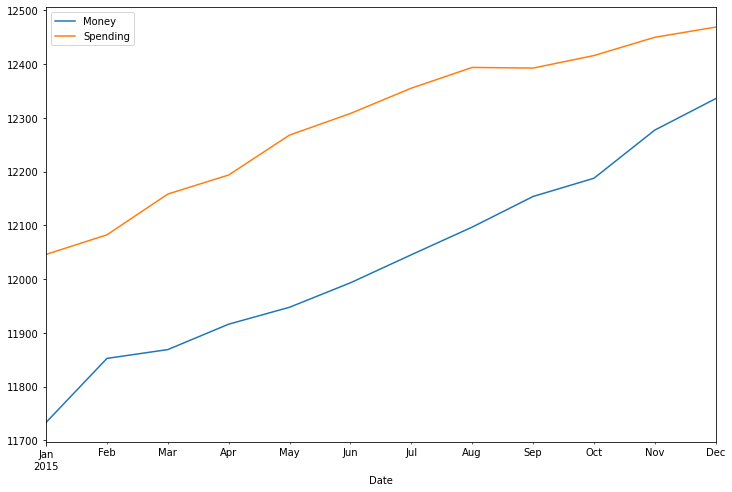

In [69]:
test_range.plot(figsize=(12,8))

In [70]:
df_forecast.columns

Index(['Money_2d', 'Spending_2d', 'Money1d', 'MoneyForecast', 'Spending1d',
       'SpendingForecast'],
      dtype='object')

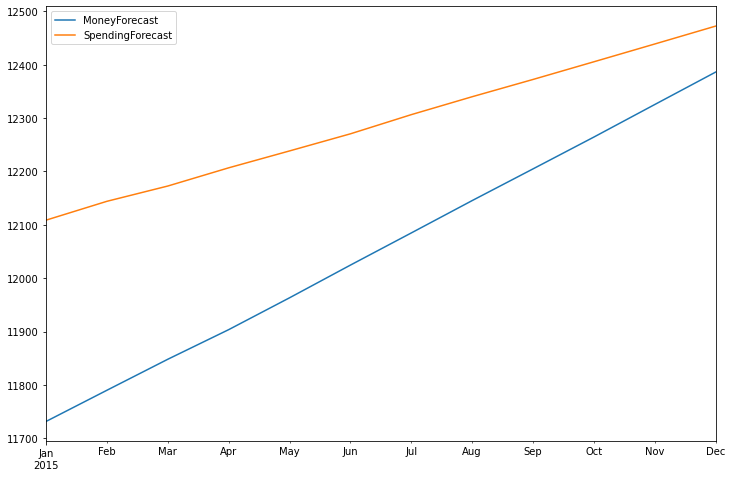

In [71]:
df_forecast[['MoneyForecast','SpendingForecast']].plot(figsize=(12,8))

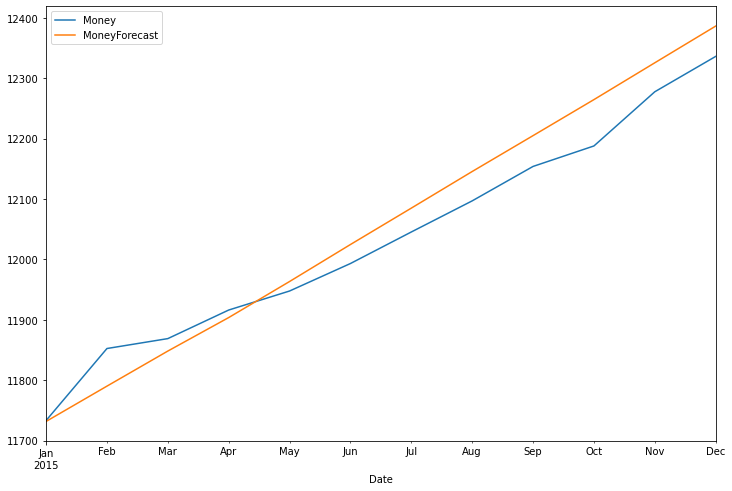

In [72]:
test_range['Money'].plot(legend=True,figsize=(12,8))
df_forecast['MoneyForecast'].plot(legend=True)

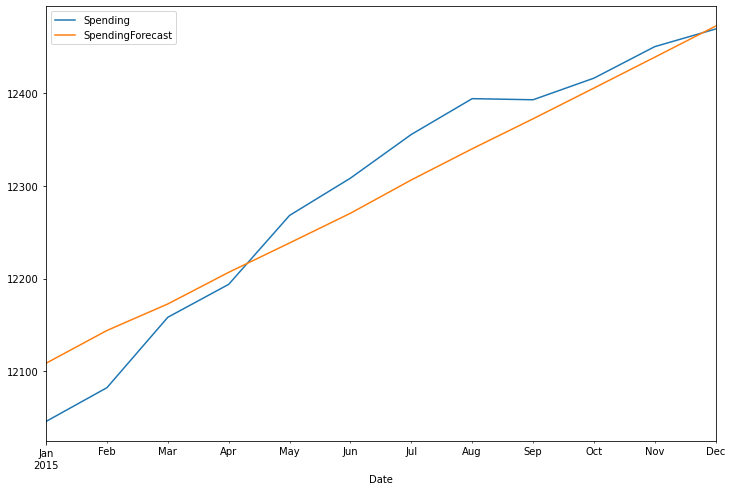

In [73]:
test_range['Spending'].plot(legend=True,figsize=(12,8))
df_forecast['SpendingForecast'].plot(legend=True)

In [74]:
rmse(test_range['Money'],df_forecast['MoneyForecast'])

43.710496535589265

In [75]:
test_range['Money'].mean()

12034.008333333333

In [76]:
rmse(test_range['Spending'],df_forecast['SpendingForecast'])

37.00117516940808

In [77]:
test_range['Spending'].mean()

12294.533333333333